<b>Autonecoder tutorial:</b>
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
</br>
<b>Deep Clustering with Convolutional Autoencoders paper:</b>
https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf

In [122]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Seed set to 42


Device: cuda:0


## Load data

In [144]:
def load_numpy_array(path):
    return np.load(path)

# TODO: not resize here, save file with right width and height
def load_img(path):
    image = Image.open(path)
    image = image.resize((32, 32))
    return np.array(image)


class FeaturesDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        feature = load_img(path)
        if self.transform:
            feature = self.transform(feature)
        return feature

### Path to images

In [145]:
project_dir = os.path.relpath(os.path.join(os.getcwd(), os.pardir))
features_dir = os.path.join(project_dir, "features")

#TODO: argument for dataset folder name
dataset_dir = os.path.join(features_dir, "music_audio_benchmark")

csv_file_name = "features.csv"
csv_file_path = os.path.join(dataset_dir, csv_file_name)

df = pd.read_csv(csv_file_path)
path_columns = [
    'name', 'path_spectogram_arr', 'path_mel_spectogram_arr', 'path_chromagram_arr', 'path_mfccs_arr', 
    'path_spectogram_img',  'path_mel_spectogram_img', 'path_chromagram_img', 'label'
]

df_paths = df[path_columns].copy()
feature = 'path_spectogram_img'
features_paths = df_paths[feature].values

### Train and validation datasets

In [146]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
transform2 = transforms.Compose([transforms.ToTensor()])

feature_dataset = FeaturesDataset(features_paths, transform=transform)

train_length = int(0.8 * len(feature_dataset))
val_length = len(feature_dataset) - train_length
train_set, val_set = torch.utils.data.random_split(feature_dataset, [train_length, val_length])

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True, num_workers=4)

### Validate if images are correctly loaded

In [147]:
def compare_imgs(img1, img2, title=""):
    loss = F.mse_loss(img1, img2, reduction="sum")
    
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(4, 2))
    plt.title(f"{title}, Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

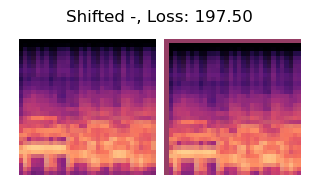

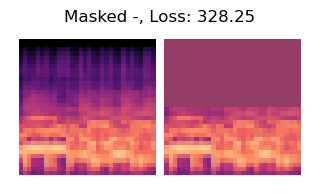

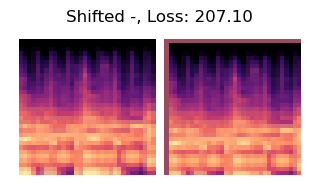

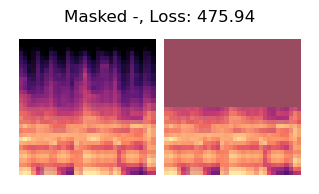

In [148]:
for i in range(2):
    # Load example image
    img = feature_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Autoencoder

In [5]:
# TODO:
# 1. try other activation_fns
# 2. change comments to proper sizes
# 3. change values to proper sizes

class Encoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, base_channel_size, kernel_size=3, padding=1, stride=2), # 32x32 -> 16x16
            activation_fn(),
            nn.Conv2d(base_channel_size, base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1, stride=2), # 16x16 -> 8x8
            activation_fn(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1, stride=2), # 8x8 -> 4x4
            activation_fn(),
            nn.Flatten(), # flatten to single feature vector
            nn.Linear(2 * base_channel_size * 4 * 4, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [7]:
# TODO:
# 1. try other activation_fns
# 2. change comments to proper sizes
# 3. change values to proper sizes
class Decoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2 * base_channel_size * 4 * 4),
            activation_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 -> 8x8
            activation_fn(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.ConvTranspose2d(base_channel_size, 2 * base_channel_size, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 -> 16x16
            activation_fn(),
            nn.Conv2d(base_channel_size, base_channel_size, kernel_size=3, padding=1),
            nn.ConvTranspose2d(base_channel_size, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 -> 32x32
            nn.Tanh() # TODO: scale images between -1 and 1
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4) # reshape tensor (spatial dimensions set to 4x4)
        x = self.net(x)
        return x

In [16]:
# TODO:
# 1. change values to proper sizes
# 2. try different loss functions

class Autoencoder(pl.LightningModule):
    """
    Inputs: 
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - encoder_class : Encoder
        - decoder_class : Decoder
        - num_input_channels : Number of input channels of the image.
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 3,
        width: int = 32,
        height: int = 32
    ):
        super().__init__()
        
        # Save hyperparameters
        self.save_hyperparameters()
        
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        
        # Example input array needed for visualizing the graph of network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    """
    The forward function takes in an image and returns the reconstructed image
    """
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    """
    Given a batch of images, this function returns the reconstruction loss (MSE in our case)
    """
    def _get_recontruction_loss(self, batch):
        x, _ = batch # Skip labels
        x_hat = self.forward(x)
        
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters, lr=1e-3)
        
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.2,
            patience=20,
            min_lr=5e-5
        )
        
        return {
            "optimizer": optimizer,
            "lr_schedule": scheduler,
            "monitor": "val_loss"
        }
    
    def training_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('test_loss', loss)

In [ ]:
class GenerateCallback(pl.Callback):
    def __init__(self, imgs, every_n_epochs=5):
        super().__init_()
        self.imgs = imgs # Images to reconstruct
        self.every_n_epochs = every_n_epochs
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            imgs = self.imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module()
                pl_module.train()
            
            images = torch.stack([imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True, range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)